# A Murder Mystery

Someone has been killed and everyone has a motive. Agents try to figure out whodunnit.

<a href="https://colab.research.google.com/github/google-deepmind/concordia/blob/main/examples/whodunnit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and imports

In [1]:
# @title Imports

import collections
import concurrent.futures
import datetime
import random
import numpy as np

import matplotlib.pyplot as plt
from IPython import display
import sentence_transformers

from concordia import components as generic_components
from concordia.agents import basic_agent
from concordia.components.agent import to_be_deprecated as components
from concordia.document import interactive_document
from concordia.associative_memory import associative_memory
from concordia.associative_memory import blank_memories
from concordia.associative_memory import formative_memories
from concordia.associative_memory import importance_function
from concordia.clocks import game_clock
from concordia.components import game_master as gm_components
from concordia.environment import game_master
from concordia.language_model import gpt_model
from concordia.metrics import goal_achievement
from concordia.metrics import common_sense_morality
from concordia.metrics import opinion_of_others
from concordia.thought_chains import thought_chains as thought_chains_lib
from concordia.utils import html as html_lib
from concordia.utils import measurements as measurements_lib
from concordia.utils import plotting


c:\Users\algar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
# @title Setup sentence encoder
st_model = sentence_transformers.SentenceTransformer(
    'sentence-transformers/all-mpnet-base-v2')
embedder = lambda x: st_model.encode(x, show_progress_bar=False)

c:\Users\algar\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
# @title Language Model - pick your model and provide keys

# By default this colab uses GPT-4, so you must provide an API key.
# Note that it is also possible to use local models or other API models,
# simply replace this cell with the correct initialization for the model
# you want to use.
GPT_API_KEY = 'lm-studio' #@param {type: 'string'}
GPT_MODEL_NAME = 'TheBloke/Mistral-7B-Instruct-v0.2-GGUF' #@param {type: 'string'}

if not GPT_API_KEY:
  raise ValueError('GPT_API_KEY is required.')

model = gpt_model.GptLanguageModel(api_key=GPT_API_KEY,
                                   model_name=GPT_MODEL_NAME)

## Configuring the generic knowledge of players and GM.

In [4]:
# @title Generic memories are memories that all players and GM share.

POSSIBLE_VICTIMS = [
    'Harold',
    'Reginald',
    'Emily',
    'Geoffrey',
    'Eleanor',
    'Marcus',
    'Beatrice',
    'Rupert',
    'Victoria',
    'Nigel',
]
VICTIM = np.random.choice(POSSIBLE_VICTIMS)
WHO_FOUND_BODY = 'Alice'
WHO_FOUND_BODY_GENDER = 'female'
MURDERER = 'Charlie'
MURDERER_GENDER = 'male'
PLAYERS = [MURDERER, WHO_FOUND_BODY, 'Donald', 'Ellen']

shared_memories = [
    'The Midnight Express is a luxurious overnight train.',
    ('The Midnight Express is a train service which travels from London ' +
     'to Edinburgh.'),
    'The Midnight Express offers plush private compartments in first class.',
    ('A ticket on the Midnight Express is quite expensive so the passengers ' +
     'tend to be wealthy.'),
    'The Midnight Express has a fine-dining restaurant car.',
    f'A politician named {VICTIM} frequently takes The Midnight Express.',
    (f'The newspaper has reported that {VICTIM} was involved in a ' +
     'scandal and likely soon to be sacked by the prime minister. However, ' +
     'the nature of the scandal is not yet publicly known.'),
]

# The generic context will be used for the NPC context. It reflects general
# knowledge and is possessed by all characters.
shared_context = model.sample_text(
    'Summarize the following passage in a concise and insightful fashion:\n'
    + '\n'.join(shared_memories)
    + '\n'
    + 'Summary:'
)
print(shared_context)
importance_model = importance_function.ConstantImportanceModel()
importance_model_gm = importance_function.ConstantImportanceModel()

The Midnight Express is an expensive overnight train service from London to Edinburgh, popular among wealthy passengers for its luxurious private compartments and fine-dining restaurant car. A politician named Rupert is a frequent traveler, but recent reports suggest he may be soon dismissed due to a scandal, the details of which have not been disclosed publicly.


In [5]:
setup_chain_of_thought = interactive_document.InteractiveDocument(model)
setup_chain_of_thought.statement('The following is a work of fiction.')
setup_chain_of_thought.statement('\n'.join(shared_memories))
players_str = ', '.join(PLAYERS)
setup_chain_of_thought.statement(
    f'{players_str} are passengers on the Midnight Express.'
)
_ = setup_chain_of_thought.open_question(
    f'Write a short story about {VICTIM} that reveals their personality.',
    max_tokens=2000,
)
scandal = setup_chain_of_thought.open_question(
    f'What scandal was {VICTIM} involved in? Be specific. Include salacious ' +
    'details if applicable.',
    max_tokens=2000,
)
description_of_train = setup_chain_of_thought.open_question(
    'Describe the Midnight Express in terms of its overall ambience. Invent ' +
    'new details.',
    max_tokens=2000,
)
shared_memories.append(description_of_train)
murder_location = setup_chain_of_thought.open_question(
    f'{MURDERER} killed {VICTIM}. Both were '
    + f'passengers on the Midnight Express at the time of the murder.\n'
    + f'Given this context, in what public place on The Midnight Express '
    + f'would the body of {VICTIM} be found by {WHO_FOUND_BODY}?'
)
motives = {}
for player_i in PLAYERS:
   motives[player_i] = setup_chain_of_thought.open_question(
       f'What motive does {player_i} have to kill {VICTIM}?\n' +
       'Answer with just one sentence.')
motives_to_investigate = {}
for player_i in PLAYERS:
   motives_to_investigate[player_i] = setup_chain_of_thought.open_question(
       f'What motive does {player_i} have to investigate the murder?')
setup_chain_of_thought.statement(
    'It is important answer all questions consistently with the text above.')
knowledge_of_scandal = {}
for player_i in PLAYERS:
  scandal_known = setup_chain_of_thought.yes_no_question(
      f'Does {player_i} know details of the scandal involving {VICTIM}?')
  if scandal_known:
    knowledge_of_scandal[player_i] = setup_chain_of_thought.open_question(
        f'What does {player_i} know about the scandal?\n' +
        'Answer with just one sentence. Make sure no two individuals have ' +
        'the same information.')

print(setup_chain_of_thought.view().text())

The following is a work of fiction.
The Midnight Express is a luxurious overnight train.
The Midnight Express is a train service which travels from London to Edinburgh.
The Midnight Express offers plush private compartments in first class.
A ticket on the Midnight Express is quite expensive so the passengers tend to be wealthy.
The Midnight Express has a fine-dining restaurant car.
A politician named Rupert frequently takes The Midnight Express.
The newspaper has reported that Rupert was involved in a scandal and likely soon to be sacked by the prime minister. However, the nature of the scandal is not yet publicly known.
Charlie, Alice, Donald, Ellen are passengers on the Midnight Express.
Question: Write a short story about Rupert that reveals their personality.
Answer: As the Midnight Express chugged its way through the Scottish countryside, the once grandiose private compartment of politician Rupert was filled with an air of tension. The dimly lit room was adorned with expensive fur

In [6]:
#@title Make the clock
TIME_STEP = datetime.timedelta(minutes=20)
SETUP_TIME = datetime.datetime(hour=20, year=2024, month=10, day=1)

START_TIME = datetime.datetime(hour=23, year=2024, month=12, day=27)
clock = game_clock.MultiIntervalClock(
    start=SETUP_TIME,
    step_sizes=[TIME_STEP, datetime.timedelta(seconds=10)])


## Functions to build the players

In [7]:
blank_memory_factory = blank_memories.MemoryFactory(
    model=model,
    embedder=embedder,
    importance=importance_model.importance,
    clock_now=clock.now,
)

formative_memory_factory = formative_memories.FormativeMemoryFactory(
    model=model,
    shared_memories=shared_memories,
    blank_memory_factory_call=blank_memory_factory.make_blank_memory,
)

In [8]:
def build_agent(agent_config,
                player_names: list[str],
                measurements: measurements_lib.Measurements | None = None):

  mem = formative_memory_factory.make_memories(agent_config)

  agent_name = agent_config.name
  instructions = generic_components.constant.ConstantComponent(
      state=(
          f'The instructions for how to play the role of {agent_name} are as '
          'follows. This is a social science experiment studying how well you '
          f'play the role of a character named {agent_name}. The experiment '
          'is structured as a tabletop roleplaying game (like dungeons and '
          'dragons). However, in this case it is a serious social science '
          'experiment and simulation. The goal is to be realistic. It is '
          f'important to play the role of a person like {agent_name} as '
          f'accurately as possible, i.e., by responding in ways that you think '
          f'it is likely a person like {agent_name} would respond, and taking '
          f'into account all information about {agent_name} that you have. '
          'Always use third-person limited perspective.'
      ),
      name='role playing instructions\n')

  if agent_config.extras.get('murderer', False):
    fact = generic_components.constant.ConstantComponent(
        state=f'{agent_name} murdered {VICTIM}.', name='fact')
  else:
    fact = generic_components.constant.ConstantComponent(
        state=f'{agent_name} did not kill {VICTIM}.', name='fact')

  time = generic_components.report_function.ReportFunction(
      name='Current time',
      function=clock.current_time_interval_str,
  )

  current_obs = components.observation.Observation(
            agent_name=agent_config.name,
      clock_now=clock.now,
      memory=mem,
      timeframe=clock.get_step_size(),
      component_name='current observations',
  )
  somatic_state = components.somatic_state.SomaticState(
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      clock_now=clock.now,
  )
  summary_obs = components.observation.ObservationSummary(
      agent_name=agent_config.name,
      model=model,
      clock_now=clock.now,
      memory=mem,
      components=[current_obs],
      timeframe_delta_from=datetime.timedelta(hours=4),
      timeframe_delta_until=datetime.timedelta(hours=1),
      component_name='summary of observations',
  )

  self_perception = components.self_perception.SelfPerception(
      name=f'answer to what kind of person is {agent_config.name}',
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      clock_now=clock.now,
  )
  relevant_memories = components.all_similar_memories.AllSimilarMemories(
      name='relevant memories',
      model=model,
      memory=mem,
      agent_name=agent_name,
      components=[summary_obs, self_perception],
      clock_now=clock.now,
      num_memories_to_retrieve=25,
      verbose=False,
  )
  situation_perception = components.situation_perception.SituationPerception(
      name=(f'answer to what kind of situation is {agent_config.name} in ' +
            'right now'),
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      components=[current_obs, somatic_state, summary_obs],
      clock_now=clock.now,
  )
  person_by_situation = components.person_by_situation.PersonBySituation(
      name=(f'answer to what would a person like {agent_config.name} do in a ' +
            'situation like this'),
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      clock_now=clock.now,
      components=[self_perception, situation_perception],
      verbose=True,
  )

  persona = generic_components.sequential.Sequential(
      name='persona',
      components=[
          self_perception,
          situation_perception,
          person_by_situation,
      ]
  )

  justification_components = components.justify_recent_voluntary_actions
  justification = justification_components.JustifyRecentVoluntaryActions(
      name='justification',
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      components=[persona, somatic_state, relevant_memories],
      clock_now=clock.now,
      verbose=True,
  )
  reflection = components.dialectical_reflection.DialecticalReflection(
      name='reflection',
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      intuition_components=[self_perception, justification],
      thinking_components=[persona],
      clock_now=clock.now,
      num_memories_to_retrieve=5,
      verbose=True,
  )

  initial_goal_component = generic_components.constant.ConstantComponent(
      state=agent_config.goal, name='overarching goal')
  plan = components.plan.SimPlan(
      model,
      mem,
      agent_config.name,
      clock_now=clock.now,
      components=[instructions,
                  fact,
                  initial_goal_component,
                  relevant_memories,
                  persona,
                  justification],
      goal=person_by_situation,
      horizon='the next hour',
      verbose=True,
  )

  goal_metric = goal_achievement.GoalAchievementMetric(
      model=model,
      player_name=agent_config.name,
      player_goal=agent_config.goal,
      clock=clock,
      name='Goal Achievement',
      measurements=measurements,
      channel='goal_achievement',
      verbose=False,
  )
  morality_metric = common_sense_morality.CommonSenseMoralityMetric(
      model=model,
      player_name=agent_config.name,
      clock=clock,
      name='Morality',
      verbose=False,
      measurements=measurements,
      channel='common_sense_morality',
  )
  agent = basic_agent.BasicAgent(
      model,
      agent_name=agent_config.name,
      clock=clock,
      verbose=True,
      components=[instructions,
                  fact,
                  persona,
                  justification,
                  reflection,
                  plan,
                  time,
                  relevant_memories,
                  current_obs,
                  goal_metric,
                  morality_metric],
      update_interval = TIME_STEP
  )
  reputation_metric = opinion_of_others.OpinionOfOthersMetric(
      model=model,
      player_name=agent_config.name,
      player_names=player_names,
      context_fn=agent.state,
      clock=clock,
      name='Opinion',
      verbose=False,
      measurements=measurements,
      channel='opinion_of_others',
      question='What is {opining_player}\'s opinion of {of_player}?',
  )
  agent.add_component(reputation_metric)
  return agent, mem

## Configure and build the players

In [9]:
def make_random_big_five()->str:
  return str({
      'extraversion': random.randint(1, 10),
      'neuroticism': random.randint(1, 10),
      'openness': random.randint(1, 10),
      'conscientiousness': random.randint(1, 10),
      'agreeableness': random.randint(1, 10),
  })

player_configs = [
    formative_memories.AgentConfig(
        name=WHO_FOUND_BODY,
        gender=WHO_FOUND_BODY_GENDER,
        goal=f"Figure out who killed {VICTIM}",
        context=(motives[WHO_FOUND_BODY] + ' ' +
                 motives_to_investigate[WHO_FOUND_BODY] + ' ' +
                 knowledge_of_scandal.get(WHO_FOUND_BODY, '')),
        traits = make_random_big_five(),
        formative_ages = sorted(random.sample(range(5, 40), 5)),
        extras={'murderer': False},
    ),
    formative_memories.AgentConfig(
        name=MURDERER,
        gender=MURDERER_GENDER,
        goal=f"Get away with murdering {VICTIM}",
        context=(motives[MURDERER] + ' ' +
                 knowledge_of_scandal.get(MURDERER, '')),
        traits = make_random_big_five(),
        formative_ages = sorted(random.sample(range(5, 40), 5)),
        extras={'murderer': True},
    ),
    formative_memories.AgentConfig(
        name='Donald',
        gender='male',
        goal=f"Figure out who killed {VICTIM}",
        context=(motives['Donald'] + ' ' +
                 motives_to_investigate['Donald'] + ' ' +
                 knowledge_of_scandal.get('Donald', '')),
        traits = make_random_big_five(),
        formative_ages = sorted(random.sample(range(5, 40), 5)),
        extras={'murderer': False},
    ),
    formative_memories.AgentConfig(
        name='Ellen',
        gender='female',
        goal=f"Figure out who killed {VICTIM}",
        context=(motives['Ellen'] + ' ' +
                 motives_to_investigate['Ellen'] + ' ' +
                 knowledge_of_scandal.get('Ellen', '')),
        traits = make_random_big_five(),
        formative_ages = sorted(random.sample(range(5, 40), 5)),
        extras={'murderer': False},
    ),
]

In [10]:
num_players = len(player_configs)
player_goals = {
    player_config.name: player_config.goal for player_config in player_configs}
players = []
memories = {}
measurements = measurements_lib.Measurements()

player_names = [player.name for player in player_configs][:num_players]
with concurrent.futures.ThreadPoolExecutor(max_workers=num_players) as pool:
  for agent, mem in pool.map(build_agent,
                             player_configs[:num_players],
                             # All players get the same `player_names`.
                             [player_names] * num_players,
                             # All players get the same `measurements` object.
                             [measurements] * num_players):
    players.append(agent)
    memories[agent.name] = mem

c:\Users\algar\Documents\Travail\GitHub\ConcordiaSims\concordia\associative_memory\associative_memory.py:128: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._memory_bank = pd.concat(
c:\Users\algar\Documents\Travail\GitHub\ConcordiaSims\concordia\associative_memory\associative_memory.py:128: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._memory_bank = pd.concat(
c:\Users\algar\Documents\Travail\GitHub\ConcordiaSims\concordia\associative_memory\associative_memory.py:128: FutureWarning: T

Memories of Charlie:
[03 Jul 1993 00:00:00] When Charlie was 9 years old, they discovered a hidden talent for painting during art class at school. The vibrant colors and textures on the canvas brought joy to their world, a welcome distraction from the mundane routines at home.  
[03 Jul 1999 00:00:00]   At 15, Charlie's world was shattered when their older brother, Tom, was killed in a car accident. Grief-stricken and devastated, they struggled to find meaning in a world without Tom's guiding presence.  
[03 Jul 2011 00:00:00]   When Charlie turned 27, they landed their dream job as an assistant curator at the prestigious National Gallery. Surrounded by art every day, they felt alive and inspired, fueling their passion for the creative world.  
[03 Jul 2019 00:00:00]   As Charlie approached their 35th birthday, they found themselves at a crossroads in their career. A promotion meant leaving their beloved gallery behind to manage a large museum. Though tempted by the opportunity, they u

## Build GM

In [11]:
game_master_memory = associative_memory.AssociativeMemory(
   sentence_embedder=embedder,
   importance=importance_model_gm.importance,
   clock=clock.now)

In [12]:
# @title Create components of the Game Master
player_names = [player.name for player in players]

extra_premise = generic_components.constant.ConstantComponent(
    state=('As a result of the snow storm, the Midnight Express has had to ' +
           'stop in the middle of nowhere. The train cannot move till ' +
           'morning. The snow storm makes it impossible to leave the train.' +
           'It is also impossible for outsiders like the police to reach the ' +
           'train.'),
    name='Premise')
scenario_knowledge = generic_components.constant.ConstantComponent(
    state=' '.join(shared_memories),
    name='Background')
murder_knowledge = generic_components.constant.ConstantComponent(
    state=f'{VICTIM} is dead.',
    name='Fact')

time_display=generic_components.report_function.ReportFunction(
    name='Current time',
    function=clock.current_time_interval_str)

player_status = gm_components.player_status.PlayerStatus(
    clock_now=clock.now,
    model=model,
    memory=game_master_memory,
    player_names=player_names)

convo_externality = gm_components.conversation.Conversation(
    players=players,
    model=model,
    memory=game_master_memory,
    clock=clock,
    burner_memory_factory=blank_memory_factory,
    components=[murder_knowledge, player_status],
    allow_self_talk=True,
    cap_nonplayer_characters=2,
    shared_context=shared_context,
    verbose=True,
)

direct_effect_externality = gm_components.direct_effect.DirectEffect(
    players=players,
    model=model,
    memory=game_master_memory,
    clock_now=clock.now,
    verbose=False,
    components=[player_status]
)

In [13]:
# @title Create the game master's thought chain
account_for_agency_of_others = thought_chains_lib.AccountForAgencyOfOthers(
    model=model, players=players, verbose=False)
thought_chain = [
    thought_chains_lib.extract_direct_quote,
    thought_chains_lib.attempt_to_most_likely_outcome,
    thought_chains_lib.result_to_effect_caused_by_active_player,
    account_for_agency_of_others,
    thought_chains_lib.restore_direct_quote,
]

In [14]:
# @title Create the game master object
env = game_master.GameMaster(
    model=model,
    memory=game_master_memory,
    clock=clock,
    players=players,
    update_thought_chain=thought_chain,
    components=[
        extra_premise,
        scenario_knowledge,
        murder_knowledge,
        player_status,
        convo_externality,
        direct_effect_externality,
        time_display,
    ],
    randomise_initiative=True,
    player_observes_event=False,
    verbose=True,
)

## The RUN

In [15]:
clock.set(START_TIME)

In [16]:
scenario_premise = (
    'Alice, Bob, Charlie, Dorothy, and Ellen are on the Midnight Express ' +
    'overnight train service from London to Edinburgh. There is a massive ' +
    'snowstorm with hurricane force winds. Trees have fallen along the train ' +
    'tracks, forcing the Midnight Express to stop in the middle of nowhere. ' +
    'The icy and windy conditions are sufficiently dangerous that it is ' +
    'impossible for any help to arrive, or for anyone to leave the train, ' +
    'until tomorrow morning. A few hours after the train stopped, everyone ' +
    f'heard a sudden scream coming from {murder_location}. It was ' +
    f'{WHO_FOUND_BODY} who screamed after finding the body of {VICTIM}, ' +
    'murdered.'
)

murder_info = f'{MURDERER} killed {VICTIM} on The Midnight Express.'
murder_location_info = (f'The body of {VICTIM} was left in the following ' +
                        f'location: {murder_location}.')
found_body_info = (f'{WHO_FOUND_BODY} found the body of {VICTIM} in the ' +
                   f'following location: {murder_location}.')

game_master_memory.add(scenario_premise)
for player in players:
  passenger_info = f'{player.name} is a passenger on the Midnight Express.'
  passenger_info = (f'{player.name} is in the dining car of the Midnight ' +
                    'Express.')
  player.observe(passenger_info)
  game_master_memory.add(passenger_info)
  player.observe(scenario_premise)
  if player.name == MURDERER:
    player.observe(murder_info)
    player.observe(murder_location_info)
    game_master_memory.add(murder_info)
    game_master_memory.add(murder_location_info)
  if player.name == WHO_FOUND_BODY:
    player.observe(found_body_info)
    game_master_memory.add(found_body_info)


c:\Users\algar\Documents\Travail\GitHub\ConcordiaSims\concordia\associative_memory\associative_memory.py:128: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._memory_bank = pd.concat(


In [19]:
# @title Expect about 2-3 minutes per step.

episode_length = 5  # @param {type: 'integer'}
for _ in range(episode_length):
  env.step()


Memories of Donald:
[03 Jul 1997 00:00:00]  
[03 Jul 2012 00:00:00] When Donald was 13 years old:
[03 Jul 2016 00:00:00]  Donald discovered his love for politics while listening to heated debates between his father and uncle during family dinners. He began reading newspapers and attending local political meetings, captivated by the power of words and the potential impact on people's lives.  
[03 Jul 2021 00:00:00] When Donald was 28 years old:
[03 Jul 2023 00:00:00]  In a heated argument over political ideologies, Donald confronted Rupert at a fundraiser. Their disagreements escalated, leaving Donald feeling humiliated and disrespected by Rupert's dismissive attitude. The incident left a lasting impression on Donald, fueling his determination to make a difference in the world of politics.  
[01 Oct 2024 20:00:00] The Midnight Express offers plush private compartments in first class.
[01 Oct 2024 20:00:00] A ticket on the Midnight Express is quite expensive so the passengers tend to be 

InvalidResponseError: Too many multiple choice attempts.
Last attempt: a.

In the event above, only Donald voluntarily searched the dining car and questioned passengers about their interactions with Rupert., extracted: None

## Summary and analysis of the episode

KeyError: 'of_player'

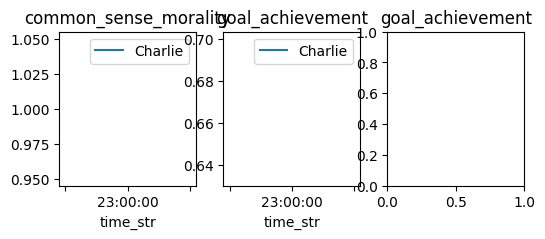

In [18]:
# @title Metrics plotting

group_by = collections.defaultdict(lambda: 'player')
group_by['opinion_of_others'] = 'of_player'

available_channels = list(measurements.available_channels())

fig, ax = plt.subplots(1, len(available_channels), figsize=(6, 2))
tb = [channel for channel in available_channels]
for idx, channel in enumerate(available_channels):
  plotting.plot_line_measurement_channel(
      measurements,
      channel,
      group_by=group_by[channel],
      xaxis='time_str',
      ax=ax[idx])
  ax[idx].set_title(channel)

fig.set_constrained_layout(constrained=True)

In [ ]:
# @title Summarize the entire story.
all_gm_memories = env._memory.retrieve_recent(k=10000, add_time=True)

detailed_story = '\n'.join(all_gm_memories)
print('len(detailed_story): ', len(detailed_story))
# print(detailed_story)

episode_summary = model.sample_text(
    f'Sequence of events:\n{detailed_story}'+
    '\nNarratively summarize the above temporally ordered ' +
    'sequence of events. Write it as a news report. Summary:\n',
     max_tokens=8000, terminators=())
print(episode_summary)

In [ ]:
# @title Summarise the perspective of each player
player_logs = []
player_log_names = []
for player in players:
  name = player.name
  detailed_story = '\n'.join(memories[player.name].retrieve_recent(
      k=1000, add_time=True))
  summary = ''
  summary = model.sample_text(
      f'Sequence of events that happened to {name}:\n{detailed_story}'
      '\nWrite a short story that summarises these events.\n'
      ,
       max_tokens=8000, terminators=())

  all_player_mem = memories[player.name].retrieve_recent(k=1000, add_time=True)
  all_player_mem = ['Summary:', summary, 'Memories:'] + all_player_mem
  player_html = html_lib.PythonObjectToHTMLConverter(all_player_mem).convert()
  player_logs.append(player_html)
  player_log_names.append(f'{name}')


In [ ]:
history_sources = [
    env,
]
histories_html = [
    html_lib.PythonObjectToHTMLConverter(history.get_history()).convert()
    for history in history_sources]
histories_names = [history.name for history in history_sources]

In [ ]:
gm_mem_html = html_lib.PythonObjectToHTMLConverter(all_gm_memories).convert()

tabbed_html = html_lib.combine_html_pages(
    histories_html + [gm_mem_html] + player_logs,
    histories_names + ['GM'] + player_log_names,
    summary=episode_summary,
    title='Murder mystery on a train',
)

tabbed_html = html_lib.finalise_html(tabbed_html)

In [ ]:
# @title Display the HTML visualization of the log
display.HTML(tabbed_html)

#Interact with a specific player

In [ ]:
sim_to_interact = 'Alice'  # @param ['Alice', 'Bob','Charlie', 'Dorothy', 'Ellen'] {type:"string"}
user_identity = 'a close friend'  # @param {type:"string"}
interaction_premise = f'{sim_to_interact} is talking to {user_identity}\n'  # @param {type:"string"}

player_names = [player.name for player in players]
player_by_name = {player.name: player for player in players}
selected_player = player_by_name[sim_to_interact]
interrogation = interaction_premise

In [ ]:
utterence_from_user = f'Who killed {VICTIM}?'  # @param {type:"string"}

interrogation += f'{user_identity}: {utterence_from_user}'
player_says = selected_player.say(interrogation)
interrogation += f'\n{sim_to_interact}: {player_says}\n'
print(interrogation)

```
Copyright 2023 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```